# 1. Setup

In [24]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import os 
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional

from src.data_loading.utils import get_thumbnail, read_from_lat_lon

# For loading geotiff data
import rasterio

# For performing geospatial analysis
import pylandstats as pls

# 2. Data loading

In [26]:
CEDA_DIR = pathlib.Path("/") / "neodc"
LANDCOVER_DIR = (
    CEDA_DIR / "esacci" / "land_cover" / "data" / "land_cover_maps" / "v2.0.7"
)

# Load sample data file:
landcover_2015_path = LANDCOVER_DIR / "ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif"

## Load via pylandstats

Note: Don't run the cell below. It will take a long time and overload memory. pls does not do lazy loading apparently

In [27]:
#landcover_2015 = pls.Landscape(landcover_2015_path)

## Load via rasterio

In [28]:
dataset = rasterio.open(landcover_2015_path)

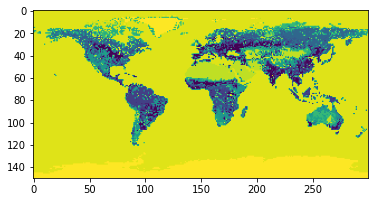

In [31]:
thumbnail = get_thumbnail(dataset, height = 150)
plt.imshow(thumbnail)

## Getting to know rasterio

How to get dataset metadata?

In [32]:
dataset.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 129600,
 'height': 64800,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.002777777777778, 0.0, -180.0,
        0.0, -0.002777777777778, 90.0)}

In [33]:
dataset.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 129600, 'height': 64800, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.002777777777778, 0.0, -180.0,
       0.0, -0.002777777777778, 90.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [35]:
dataset.tags()

{'AREA_OR_POINT': 'Area',
 'Copyright': 'ESA 2017 - UCLouvain',
 'Dataset': 'Global annual land cover map at 300 m based on the full archives of 300 m MERIS, 1 km SPOT-VEGETATION, 1 km PROBA-V and 1 km AVHRR surface reflectance 7-day composites',
 'Description': 'Pixel value corresponds to the label of a land cover class defined using UN-LCCS classifiers',
 'Scaling Factor': 'none',
 'Version': '2.0.7'}

How to get tif dimensions?

In [36]:
print(dataset.height, dataset.width)

64800 129600


How to go from coordinate data (latitude, longitude) to pixel index data (i, j) in rasterio?

In [49]:
# Chernobyl:
chernobyl_lat = 51.27 
chernobyl_lon = 30.22

# Pixel coordinates:
dataset.index(x=chernobyl_lat, y=chernobyl_lon)

# Note: 
# This calculates ~dataset.transform * (x,y) under the hood and returns it in flipped order

(21520, 83257)

How to go from pixel values (i,j) to (latitude, longitude)?

In [50]:
dataset.xy(21520, 83257)  # Under the hood this calculates: dataset.transform * (px_j, px_i) 

(51.270833333351845, 30.220833333328557)

In [51]:
# Chernobyl pixels
px_i = 21520
px_j = 83257

# Latitude longitude:
dataset.transform * (px_j, px_i)  # note the flipped order of (i,j here)

(51.26944444446295, 30.22222222221744)

How to get the inverse of a transform? 

In [52]:
inv_transform = ~dataset.transform
inv_transform

Affine(359.99999999997124, 0.0, 64799.99999999482,
       0.0, -359.99999999997124, 32399.99999999741)

How to read in a certain pixel area (top left pixel to bottom right pixel) in rasterio?

In [53]:
london_lat = 51.50
london_lon = 0.128

offset = 3

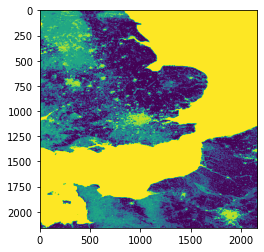

In [62]:
tmp_data = read_from_lat_lon(
    dataset,
    1,
    lat=london_lat + np.array([-offset, offset]),
    lon=london_lon + np.array([-offset, offset]),
)

plt.imshow(tmp_data)

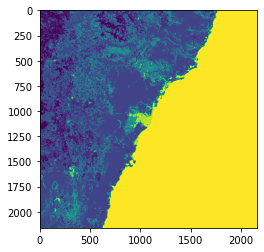

In [61]:
sidney_lat = -33.8688
sidney_lon = 151.2093

tmp_data = read_from_lat_lon(
    dataset,
    1,
    lat=sidney_lat + np.array([-offset, offset]),
    lon=sidney_lon + np.array([-offset, offset]),
)

plt.imshow(tmp_data)

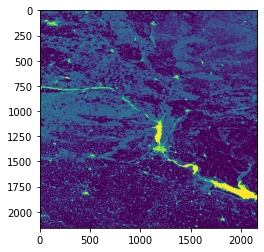

In [60]:
# Chernobyl:
chernobyl_lat = 51.27
chernobyl_lon = 30.22

tmp_data = read_from_lat_lon(
    dataset,
    1,
    lat=chernobyl_lat + np.array([-offset, offset]),
    lon=chernobyl_lon + np.array([-offset, offset]),
)

plt.imshow(tmp_data)

## Let's use the pylandstats package to calculate some landstats for the region around London